# Baseline model 

As a baseline model we will use ResNet 18 pre-trained on ImageNet.
![Original ResNet-18 Architecture](data/Original-ResNet-18-Architecture.png)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [14]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])


In [15]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In order to adapt our labels to multi-class classification task we map every binary label into a single vector of indices.

In [16]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [17]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)


In [18]:
labels['label'].value_counts()

label
4    3209
6    2020
7    2009
1    1329
2     586
5     452
0     325
3      70
Name: count, dtype: int64

In [19]:
labels = labels.drop(columns=LABELS)

In [20]:
class MatchDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, str(row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label


We first split the data in train, val and test, and then we preprocess them normalizing with the predefined Resnet method

In [21]:
# preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# split the dataset into train, validation, and test sets
image_path = 'data/selected_images'
train_dataset, test_dataset = train_test_split(labels, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_dataset_prep = MatchDataset(train_dataset, image_path, transform)
test_dataset_prep = MatchDataset(test_dataset, image_path, transform)
val_dataset_prep = MatchDataset(val_dataset, image_path, transform)


## Model fine-tuning and training 

We set some standard hyperparameters that will remain consistent in every model. Then we perform fine-tuning by replacing the last layer od the architecture with a layer that predicts 8 different classes, i.e. the number of different match events that we want to predict.

In [22]:
# model and hyperparameters
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(device)

batch_size = 32
learning_rate = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(train_dataset_prep, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_prep, batch_size=batch_size)
test_loader = DataLoader(test_dataset_prep, batch_size=batch_size)

In [23]:
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'models/resnet18_baseline.pth')
        print("Saved new best model!\n")

print("Training complete.")

[1/10] Train Loss: 0.8718, Acc: 70.47%, Val Loss: 0.8545, Acc: 69.94%
Saved new best model!

[2/10] Train Loss: 0.5561, Acc: 80.61%, Val Loss: 0.5881, Acc: 79.25%
Saved new best model!

[3/10] Train Loss: 0.4531, Acc: 84.25%, Val Loss: 0.7115, Acc: 75.25%
[4/10] Train Loss: 0.3607, Acc: 87.61%, Val Loss: 0.5059, Acc: 83.44%
Saved new best model!

[5/10] Train Loss: 0.3072, Acc: 89.03%, Val Loss: 0.5369, Acc: 82.75%
[6/10] Train Loss: 0.2170, Acc: 92.33%, Val Loss: 0.8227, Acc: 78.62%
[7/10] Train Loss: 0.1834, Acc: 93.64%, Val Loss: 0.7194, Acc: 79.38%
[8/10] Train Loss: 0.1559, Acc: 94.61%, Val Loss: 0.6538, Acc: 82.06%
[9/10] Train Loss: 0.0910, Acc: 96.98%, Val Loss: 0.7320, Acc: 80.94%
[10/10] Train Loss: 0.0969, Acc: 96.78%, Val Loss: 0.9560, Acc: 77.75%
Training complete.


## Inference on test set and evaluation

In [24]:
model.load_state_dict(torch.load('models/resnet18_baseline.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

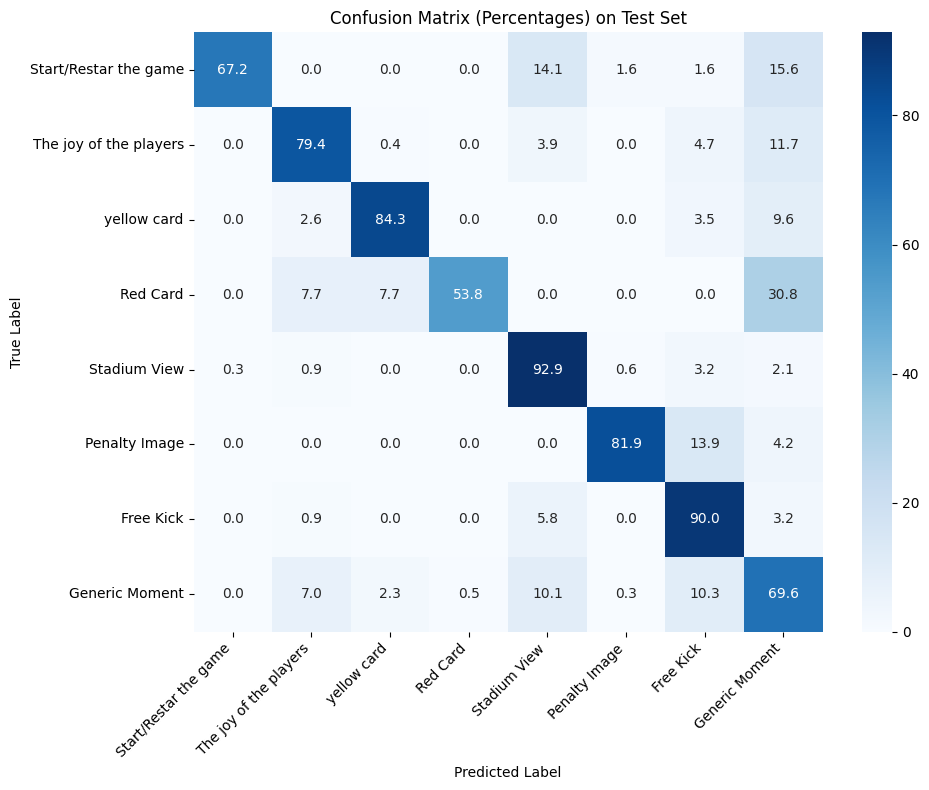

In [26]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(LABELS))))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentages) on Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_correct = [0] * len(LABELS)
class_total = [0] * len(LABELS)

for i in range(len(all_labels)):
    label = all_labels[i]
    pred = all_preds[i]
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_accuracies = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

overall_accuracy = sum(class_correct) / sum(class_total) * 100

# per-class accuracy table
print(f"{'Class':<25}{'Accuracy':>10}")
print("-" * 35)
for label, acc in zip(LABELS, class_accuracies):
    print(f"{label:<25}{acc:>9.2f}%")
print("-" * 35)
print(f"{'Overall':<25}{overall_accuracy:>9.2f}")

Class                      Accuracy
-----------------------------------
Start/Restar the game        67.19%
The joy of the players       79.38%
yellow card                  84.35%
Red Card                     53.85%
Stadium View                 92.88%
Penalty Image                81.94%
Free Kick                    90.02%
Generic Moment               69.59%
-----------------------------------
Overall                      84.05


Now we use some metrics more suitable to evaluate a model performing inference on unbalanced classes.

In [28]:
report = classification_report(all_labels, all_preds, 
                               target_names=LABELS, 
                               digits=3)
print(report)

                        precision    recall  f1-score   support

 Start/Restar the game      0.956     0.672     0.789        64
The joy of the players      0.833     0.794     0.813       257
           yellow card      0.898     0.843     0.870       115
              Red Card      0.778     0.538     0.636        13
          Stadium View      0.881     0.929     0.904       660
         Penalty Image      0.908     0.819     0.861        72
             Free Kick      0.815     0.900     0.856       431
        Generic Moment      0.758     0.696     0.726       388

              accuracy                          0.841      2000
             macro avg      0.853     0.774     0.807      2000
          weighted avg      0.840     0.841     0.838      2000



From the per-class results of the baseline model, we observe significant performance disparities across different football match events, largely reflecting the underlying class imbalance in our dataset. Indeed, the model demonstrates excellent performance on high-frequency events such as "Stadium View" (92.88% accuracy) and "Free Kick" (90.02% accuracy). Conversely, rare events like "Red Card" show substantially lower accuracy (53.85%), indicating the model's difficulty in learning discriminative features from limited samples. Interestingly, while "Start/Restart the game" achieves high precision (95.6%), its recall drops significantly (67.2%), suggesting the model is conservative in predicting this class. \
Finally, the "Generic Moment" class, despite having substantial support, shows moderate performance (69.59% accuracy), likely due to its inherent ambiguity and diverse visual characteristics that make it challenging to distinguish from other specific events.

For the overall metrics we choose 'weighted' type of metric because it weights each class by its frequency.

In [29]:
# Weighted versions
weighted_precision = precision_score(all_labels, all_preds, average='weighted')
weighted_recall = recall_score(all_labels, all_preds, average='weighted')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {overall_accuracy/100:.3f}")
print(f"Weighted Precision: {weighted_precision:.3f}")
print(f"Weighted Recall: {weighted_recall:.3f}")
print(f"Weighted F1 Score: {weighted_f1:.3f}")

Accuracy: 0.841
Weighted Precision: 0.840
Weighted Recall: 0.841
Weighted F1 Score: 0.838
